# SSD Evaluation Tutorial

This is a brief tutorial that explains how compute the average precisions for any trained SSD model using the `Evaluator` class. The `Evaluator` computes the average precisions according to the Pascal VOC pre-2010 or post-2010 detection evaluation algorithms. You can find details about these computation methods [here](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/htmldoc/devkit_doc.html#sec:ap).

As an example we'll evaluate an SSD300 on the Pascal VOC 2007 `test` dataset, but note that the `Evaluator` works for any SSD model and any dataset that is compatible with the `DataGenerator`. If you would like to run the evaluation on a different model and/or dataset, the procedure is analogous to what is shown below, you just have to build the appropriate model and load the relevant dataset.

Note: I that in case you would like to evaluate a model on MS COCO, I would recommend to follow the [MS COCO evaluation notebook](https://github.com/pierluigiferrari/ssd_keras/blob/master/ssd300_evaluation_COCO.ipynb) instead, because it can produce the results format required by the MS COCO evaluation server and uses the official MS COCO evaluation code, which computes the mAP slightly differently from the Pascal VOC method.

Note: In case you want to evaluate any of the provided trained models, make sure that you build the respective model with the correct set of scaling factors to reproduce the official results. The models that were trained on MS COCO and fine-tuned on Pascal VOC require the MS COCO scaling factors, not the Pascal VOC scaling factors.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = str(3)

from tqdm.autonotebook import tqdm

from keras import backend as K
from keras.models import load_model
from keras.optimizers import Adam
#from scipy.misc import imread
import numpy as np
from matplotlib import pyplot as plt

from ssd_keras.models.keras_ssd300 import ssd_300
from ssd_keras.keras_loss_function.keras_ssd_loss import SSDLoss
from ssd_keras.keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from ssd_keras.keras_layers.keras_layer_DecodeDetections import DecodeDetections
from ssd_keras.keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from ssd_keras.keras_layers.keras_layer_L2Normalization import L2Normalization
from ssd_keras.data_generator.object_detection_2d_data_generator import DataGenerator
from ssd_keras.eval_utils.average_precision_evaluator import Evaluator

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
#from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import cv2

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf
from keras_retinanet import models

%matplotlib inline

/caa/Homes01/mburges/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  after removing the cwd from sys.path.
Using TensorFlow backend.


In [2]:
# Set a few configuration parameters.
img_height = 960
img_width = 720
n_classes = 5
model_mode = 'inference'

## 1. Load a trained SSD

Either load a trained model or build a model and load trained weights into it. Since the HDF5 files I'm providing contain only the weights for the various SSD versions, not the complete models, you'll have to go with the latter option when using this implementation for the first time. You can then of course save the model and next time load the full model directly, without having to build it.

You can find the download links to all the trained model weights in the README.

### 1.1. Build the model and load trained weights into it

In [3]:
# adjust this to point to your downloaded/trained model
# models can be downloaded here: https://github.com/fizyr/keras-retinanet/releases
model_path = os.path.join('keras_retinanet', 'snapshots', 'resnet50_pascal_50.h5')

# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')

model = models.convert_model(model)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_1:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_2:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_3:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_4:0' shape=(9, 4) dtype=float32> anchors


## 2. Create a data generator for the evaluation dataset

Instantiate a `DataGenerator` that will serve the evaluation dataset during the prediction phase.

In [4]:
dataset = DataGenerator()

# TODO: Set the paths to the dataset here.
Pascal_VOC_dataset_images_dir = '/caa/Homes01/mburges/CVSP-Object-Detection-Historical-Videos/VOCTemplate/VOC2019/JPEGImages/'
Pascal_VOC_dataset_annotations_dir = '/caa/Homes01/mburges/CVSP-Object-Detection-Historical-Videos/VOCTemplate/VOC2019/Annotations/'
Pascal_VOC_dataset_image_set_filename = '/caa/Homes01/mburges/CVSP-Object-Detection-Historical-Videos/VOCTemplate/VOC2019/ImageSets/Main/val.txt'

# The XML parser needs to now what object class names to look for and in which order to map them to integers.
classes = ['crowd', 'civilian', 'soldier', 'civil vehicle', 'military vehicle']

dataset.parse_xml(images_dirs=[Pascal_VOC_dataset_images_dir],
                  image_set_filenames=[Pascal_VOC_dataset_image_set_filename],
                  annotations_dirs=[Pascal_VOC_dataset_annotations_dir],
                  classes=classes,
                  include_classes='all',
                  exclude_truncated=False,
                  exclude_difficult=False,
                  ret=False)

Processing image set 'val.txt': 100%|██████████| 109/109 [00:00<00:00, 213.89it/s]


## 3. Run the evaluation

Now that we have instantiated a model and a data generator to serve the dataset, we can set up the evaluator and run the evaluation.

The evaluator is quite flexible: It can compute the average precisions according to the Pascal VOC pre-2010 algorithm, which samples 11 equidistant points of the precision-recall curves, or according to the Pascal VOC post-2010 algorithm, which integrates numerically over the entire precision-recall curves instead of sampling a few individual points. You could also change the number of sampled recall points or the required IoU overlap for a prediction to be considered a true positive, among other things. Check out the `Evaluator`'s documentation for details on all the arguments.

In its default settings, the evaluator's algorithm is identical to the official Pascal VOC pre-2010 Matlab detection evaluation algorithm, so you don't really need to tweak anything unless you want to.

The evaluator roughly performs the following steps: It runs predictions over the entire given dataset, then it matches these predictions to the ground truth boxes, then it computes the precision-recall curves for each class, then it samples 11 equidistant points from these precision-recall curves to compute the average precision for each class, and finally it computes the mean average precision over all classes.

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'annotations_dirs', 'classes', 'create_hdf5_dataset', 'dataset_indices', 'dataset_size', 'eval_neutral', 'filenames', 'generate', 'get_dataset', 'get_dataset_size', 'hdf5_dataset', 'image_ids', 'image_set_filenames', 'images', 'images_dirs', 'include_classes', 'labels', 'labels_format', 'labels_output_format', 'load_hdf5_dataset', 'load_images_into_memory', 'parse_csv', 'parse_json', 'parse_xml', 'save_dataset']
<generator object DataGenerator.generate at 0x7f96b5df33d0>


In [5]:
evaluator = Evaluator(model=model,
                      n_classes=n_classes,
                      data_generator=dataset,
                      model_mode=model_mode)

results = evaluator(img_height=img_height,
                    img_width=img_width,
                    batch_size=8,
                    data_generator_mode='resize',
                    round_confidences=False,
                    matching_iou_threshold=0.5,
                    border_pixels='include',
                    sorting_algorithm='quicksort',
                    average_precision_mode='sample',
                    num_recall_points=11,
                    ignore_neutral_boxes=True,
                    return_precisions=True,
                    return_recalls=True,
                    return_average_precisions=True,
                    verbose=True)

mean_average_precision, average_precisions, precisions, recalls = results

Number of images in the evaluation dataset: 109

Producing predictions batch-wise:   0%|          | 0/14 [00:00<?, ?it/s]3
[array([[[368.4286  , 222.56482 , 566.9092  , 807.9052  ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        ...,
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ]],

       [[110.71087 , 430.76382 , 270.67007 , 902.18207 ],
        [477.12454 , 499.49664 , 555.05237 , 727.43866 ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        ...,
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ]],

       [[ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  

TypeError: list indices must be integers or slices, not tuple

## 4. Visualize the results

Let's take a look:

In [7]:
print(len(average_precisions))
for i in range(1, 3):
    print("{:<14}{:<6}{}".format(classes[i], 'AP', round(average_precisions[i], 3)))
print()
print("{:<14}{:<6}{}".format('','mAP', round(mean_average_precision, 3)))

5
civilian      AP    0.465
soldier       AP    0.413

              mAP   0.345


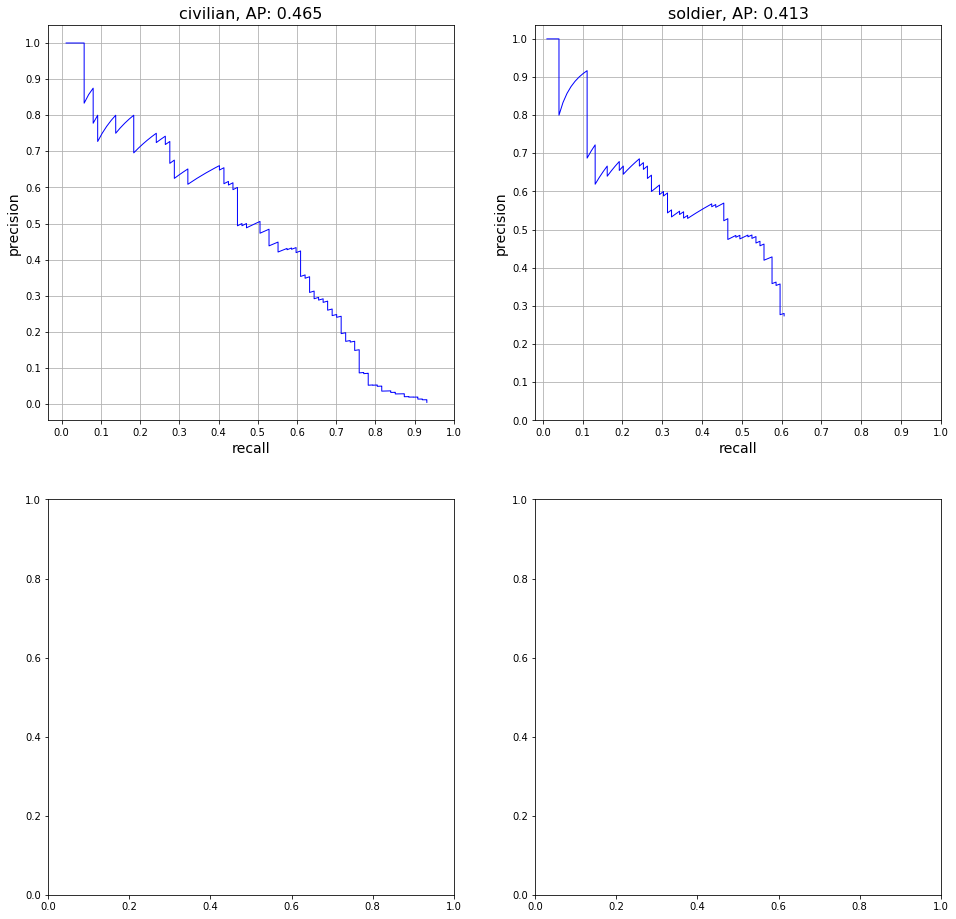

In [8]:
m = max((2 + 1) // 2, 2)
n = 2

fig, cells = plt.subplots(m, n, figsize=(n*8,m*8))
for i in range(m):
    for j in range(n):
        if n*i+j+1 > 2: break
        cells[i, j].plot(recalls[n*i+j+1], precisions[n*i+j+1], color='blue', linewidth=1.0)
        cells[i, j].set_xlabel('recall', fontsize=14)
        cells[i, j].set_ylabel('precision', fontsize=14)
        cells[i, j].grid(True)
        cells[i, j].set_xticks(np.linspace(0,1,11))
        cells[i, j].set_yticks(np.linspace(0,1,11))
        cells[i, j].set_title("{}, AP: {:.3f}".format(classes[n*i+j+1], average_precisions[n*i+j+1]), fontsize=16)

## 5. Advanced use

`Evaluator` objects maintain copies of all relevant intermediate results like predictions, precisions and recalls, etc., so in case you want to experiment with different parameters, e.g. different IoU overlaps, there is no need to compute the predictions all over again every time you make a change to a parameter. Instead, you can only update the computation from the point that is affected onwards.

The evaluator's `__call__()` method is just a convenience wrapper that executes its other methods in the correct order. You could just call any of these other methods individually as shown below (but you have to make sure to call them in the correct order).

Note that the example below uses the same evaluator object as above. Say you wanted to compute the Pascal VOC post-2010 'integrate' version of the average precisions instead of the pre-2010 version computed above. The evaluator object still has an internal copy of all the predictions, and since computing the predictions makes up the vast majority of the overall computation time and since the predictions aren't affected by changing the average precision computation mode, we skip computing the predictions again and instead only compute the steps that come after the prediction phase of the evaluation. We could even skip the matching part, since it isn't affected by changing the average precision mode either. In fact, we would only have to call `compute_average_precisions()` `compute_mean_average_precision()` again, but for the sake of illustration we'll re-do the other computations, too.

In [12]:
evaluator.get_num_gt_per_class(ignore_neutral_boxes=True,
                               verbose=False,
                               ret=False)

evaluator.match_predictions(ignore_neutral_boxes=True,
                            matching_iou_threshold=0.5,
                            border_pixels='include',
                            sorting_algorithm='quicksort',
                            verbose=True,
                            ret=False)

precisions, recalls = evaluator.compute_precision_recall(verbose=True, ret=True)

average_precisions = evaluator.compute_average_precisions(mode='integrate',
                                                          num_recall_points=11,
                                                          verbose=True,
                                                          ret=True)

mean_average_precision = evaluator.compute_mean_average_precision(ret=True)

Matching predictions to ground truth, class 1/20.: 100%|██████████| 7902/7902 [00:00<00:00, 19849.68it/s]
Matching predictions to ground truth, class 2/20.: 100%|██████████| 4276/4276 [00:00<00:00, 21798.36it/s]
Matching predictions to ground truth, class 3/20.: 100%|██████████| 19126/19126 [00:00<00:00, 28263.72it/s]
Matching predictions to ground truth, class 4/20.: 100%|██████████| 25291/25291 [00:01<00:00, 20847.78it/s]
Matching predictions to ground truth, class 5/20.: 100%|██████████| 33520/33520 [00:00<00:00, 34610.95it/s]
Matching predictions to ground truth, class 6/20.: 100%|██████████| 4395/4395 [00:00<00:00, 23612.98it/s]
Matching predictions to ground truth, class 7/20.: 100%|██████████| 41833/41833 [00:02<00:00, 20821.01it/s]
Matching predictions to ground truth, class 8/20.: 100%|██████████| 2740/2740 [00:00<00:00, 25909.74it/s]
Matching predictions to ground truth, class 9/20.: 100%|██████████| 91992/91992 [00:03<00:00, 25150.58it/s]
Matching predictions to ground truth

In [17]:
for i in range(1, len(average_precisions)):
    print("{:<14}{:<6}{}".format(classes[i], 'AP', round(average_precisions[i], 3)))
print()
print("{:<14}{:<6}{}".format('','mAP', round(mean_average_precision, 3)))

aeroplane     AP    0.822
bicycle       AP    0.874
bird          AP    0.787
boat          AP    0.713
bottle        AP    0.505
bus           AP    0.899
car           AP    0.89
cat           AP    0.923
chair         AP    0.61
cow           AP    0.845
diningtable   AP    0.79
dog           AP    0.899
horse         AP    0.903
motorbike     AP    0.875
person        AP    0.825
pottedplant   AP    0.526
sheep         AP    0.811
sofa          AP    0.83
train         AP    0.906
tvmonitor     AP    0.797

              mAP   0.802
